In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def transform_data_datetime(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['DATE'], format="%Y%m%d")
    df['year'] = df['datetime'].dt.year
    df['month int'] = df['datetime'].dt.month
    df['month'] = df['datetime'].dt.strftime('%b')
    df['month'] = pd.Categorical(df['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

    df['day'] = df['datetime'].dt.day


    return df

# Heathrow Precipitation Data

This notebook provides information about the daily precipitation recorded in Heathrow weather station by [European Climate Assessment and Dataset website.](https://www.ecad.eu/)

The website allows you to download data from different stations and Heathrow's one is the best option to perform the intended analysis. The data we will use in this notebook are the one contained in the `RR_SOUID219137.csv` file. 

In [3]:
heathrow_daily_data = pd.read_csv('./data/non_blended/RR_SOUID107650.csv')
print(heathrow_daily_data.shape)
heathrow_daily_data.head()

(23862, 5)


,STAID,SOUID,DATE,RR,Q_RR
0,1860,107650,19600101,22,0
1,1860,107650,19600102,23,0
2,1860,107650,19600103,7,0
3,1860,107650,19600104,0,0
4,1860,107650,19600105,0,0


In [4]:
heathrow_daily_data.dtypes

STAID    int64
SOUID    int64
DATE     int64
RR       int64
Q_RR     int64
dtype: object

In [5]:
# Adding columns for handling dates
heathrow_daily_data = transform_data_datetime(heathrow_daily_data)

In [6]:
heathrow_daily_data.head()

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day
0,1860,107650,19600101,22,0,1960-01-01,1960,1,Jan,1
1,1860,107650,19600102,23,0,1960-01-02,1960,1,Jan,2
2,1860,107650,19600103,7,0,1960-01-03,1960,1,Jan,3
3,1860,107650,19600104,0,0,1960-01-04,1960,1,Jan,4
4,1860,107650,19600105,0,0,1960-01-05,1960,1,Jan,5


The `RR` unit is 0.1mm, we create a collumn rr_mm that contains the same measurement but in 1mm unit.

In [7]:
heathrow_daily_data['RR_mm'] = heathrow_daily_data['RR'] * 0.1
heathrow_daily_data.sort_values('datetime').reset_index(inplace=True, drop=True)
heathrow_daily_data[['RR_mm']].head()

,RR_mm
0,2.2
1,2.3
2,0.7
3,0.0
4,0.0


### Handling Missing Reading

The dataframe column `Q_RR` indicates the quality of each reading and our dataset contains few missing reading.

In [8]:
print(heathrow_daily_data[heathrow_daily_data['Q_RR'] !=0].shape[0])
heathrow_daily_data[heathrow_daily_data['Q_RR'] !=0]

14


,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
13300,1860,107650,19960531,-9999,9,1996-05-31,1996,5,May,31,-999.9
13683,1860,107650,19970618,-9999,9,1997-06-18,1997,6,Jun,18,-999.9
13684,1860,107650,19970619,-9999,9,1997-06-19,1997,6,Jun,19,-999.9
13685,1860,107650,19970620,-9999,9,1997-06-20,1997,6,Jun,20,-999.9
13686,1860,107650,19970621,-9999,9,1997-06-21,1997,6,Jun,21,-999.9
13687,1860,107650,19970622,-9999,9,1997-06-22,1997,6,Jun,22,-999.9
13688,1860,107650,19970623,-9999,9,1997-06-23,1997,6,Jun,23,-999.9
13689,1860,107650,19970624,-9999,9,1997-06-24,1997,6,Jun,24,-999.9
13690,1860,107650,19970625,-9999,9,1997-06-25,1997,6,Jun,25,-999.9
13691,1860,107650,19970626,-9999,9,1997-06-26,1997,6,Jun,26,-999.9


We have 14 missing reading, 1 is from May the 5th 1996 and from 18th to 30th of June 1997. Altough our analysis will be focused on the last 15 years, it is a good exercise to fill this missing reading. As a first step, we can transform the `RR` and `RR_mm` reading, corresponding to a `Q_RR` code of $9$, into a more easy to handle `np.nan`

In [9]:
heathrow_daily_data.loc[heathrow_daily_data['Q_RR'] !=0, ['RR_mm', 'RR']] = np.nan 

In [10]:
heathrow_daily_data[heathrow_daily_data['RR_mm'].isna()]

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
13300,1860,107650,19960531,NaN,9,1996-05-31,1996,5,May,31,NaN
13683,1860,107650,19970618,NaN,9,1997-06-18,1997,6,Jun,18,NaN
13684,1860,107650,19970619,NaN,9,1997-06-19,1997,6,Jun,19,NaN
13685,1860,107650,19970620,NaN,9,1997-06-20,1997,6,Jun,20,NaN
13686,1860,107650,19970621,NaN,9,1997-06-21,1997,6,Jun,21,NaN
13687,1860,107650,19970622,NaN,9,1997-06-22,1997,6,Jun,22,NaN
13688,1860,107650,19970623,NaN,9,1997-06-23,1997,6,Jun,23,NaN
13689,1860,107650,19970624,NaN,9,1997-06-24,1997,6,Jun,24,NaN
13690,1860,107650,19970625,NaN,9,1997-06-25,1997,6,Jun,25,NaN
13691,1860,107650,19970626,NaN,9,1997-06-26,1997,6,Jun,26,NaN


There are different strategy to fill this missing reading. The best approach would be to find alternative sources containing the missing data and but in our example, we will use the available data.

As we can see, there is a isolated day, 1996-05-31, and a series of consecutive days without reading. A sensitive approach could be using a simple mean value of the days before and after for that date.

In [11]:
## filling single date 1996-05-31

idx = heathrow_daily_data[heathrow_daily_data['datetime'] == "1996-05-31"].index[0]

mean_RR_m_value = heathrow_daily_data.iloc[idx-2:idx+3]['RR_mm'].mean()
mean_RR_value = heathrow_daily_data.iloc[idx-2:idx+3]['RR'].mean()

heathrow_daily_data.loc[idx, 'RR'] = mean_RR_value
heathrow_daily_data.loc[idx, 'RR_mm'] = mean_RR_m_value

In [12]:
heathrow_daily_data[heathrow_daily_data['datetime'] == "1996-05-31"]

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
13300,1860,107650,19960531,0.5,9,1996-05-31,1996,5,May,31,0.05


As for the missing readings between the 18th and 30th of June 1997, we can calculate the daily mean within that datetime range for each year and fill the missing data. 

In [13]:
heathrow_fillin_data = heathrow_daily_data[(heathrow_daily_data['month'] == 'Jun') &
                                           ((heathrow_daily_data['day'] >=18) & (heathrow_daily_data['day'] <= 30)) &
                                           (heathrow_daily_data['Q_RR'] == 0)].reset_index(drop = True).copy()
heathrow_fillin_data.head()


,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
0,1860,107650,19600618,0.0,0,1960-06-18,1960,6,Jun,18,0.0
1,1860,107650,19600619,0.0,0,1960-06-19,1960,6,Jun,19,0.0
2,1860,107650,19600620,0.0,0,1960-06-20,1960,6,Jun,20,0.0
3,1860,107650,19600621,0.0,0,1960-06-21,1960,6,Jun,21,0.0
4,1860,107650,19600622,141.0,0,1960-06-22,1960,6,Jun,22,14.1


In [14]:
heathrow_1997_fillin = (heathrow_fillin_data
                        .groupby(['month', 'day'])[['RR', 'RR_mm']]
                        .mean()
                        .reset_index()
                        )

heathrow_1997_fillin['year'] = 1997
heathrow_1997_fillin

C:\Users\pacor\AppData\Local\Temp\ipykernel_14708\1254895261.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['month', 'day'])[['RR', 'RR_mm']]


,month,day,RR,RR_mm,year
0,Jan,18,NaN,NaN,1997
1,Jan,19,NaN,NaN,1997
2,Jan,20,NaN,NaN,1997
3,Jan,21,NaN,NaN,1997
4,Jan,22,NaN,NaN,1997
...,...,...,...,...,...
151,Dec,26,NaN,NaN,1997
152,Dec,27,NaN,NaN,1997
153,Dec,28,NaN,NaN,1997
154,Dec,29,NaN,NaN,1997


In [15]:
merged = heathrow_daily_data.merge(
    heathrow_1997_fillin, 
    on=['year', 'month', 'day'], 
    how='left', 
    suffixes=('', '_fill')
)

merged[merged['RR_mm'].isna()]

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm,RR_fill,RR_mm_fill
13683,1860,107650,19970618,NaN,9,1997-06-18,1997,6,Jun,18,NaN,19.234375,1.923438
13684,1860,107650,19970619,NaN,9,1997-06-19,1997,6,Jun,19,NaN,15.515625,1.551562
13685,1860,107650,19970620,NaN,9,1997-06-20,1997,6,Jun,20,NaN,10.937500,1.093750
13686,1860,107650,19970621,NaN,9,1997-06-21,1997,6,Jun,21,NaN,11.046875,1.104688
13687,1860,107650,19970622,NaN,9,1997-06-22,1997,6,Jun,22,NaN,22.343750,2.234375
13688,1860,107650,19970623,NaN,9,1997-06-23,1997,6,Jun,23,NaN,18.546875,1.854688
13689,1860,107650,19970624,NaN,9,1997-06-24,1997,6,Jun,24,NaN,10.796875,1.079688
13690,1860,107650,19970625,NaN,9,1997-06-25,1997,6,Jun,25,NaN,16.921875,1.692187
13691,1860,107650,19970626,NaN,9,1997-06-26,1997,6,Jun,26,NaN,15.703125,1.570312
13692,1860,107650,19970627,NaN,9,1997-06-27,1997,6,Jun,27,NaN,21.765625,2.176563


In [16]:
# Fill NaN values in original columns with values from fill-in dataframe
merged['RR'] = merged['RR'].fillna(merged['RR_fill'])
merged['RR_mm'] = merged['RR_mm'].fillna(merged['RR_mm_fill'])

In [17]:
merged[(merged['month'] == 'Jun') &
       ((merged['day'] >=18) & (merged['day'] <= 30)) &
       (merged['year'] == 1997)].reset_index(drop = True).copy()

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm,RR_fill,RR_mm_fill
0,1860,107650,19970618,19.234375,9,1997-06-18,1997,6,Jun,18,1.923438,19.234375,1.923438
1,1860,107650,19970619,15.515625,9,1997-06-19,1997,6,Jun,19,1.551562,15.515625,1.551562
2,1860,107650,19970620,10.937500,9,1997-06-20,1997,6,Jun,20,1.093750,10.937500,1.093750
3,1860,107650,19970621,11.046875,9,1997-06-21,1997,6,Jun,21,1.104688,11.046875,1.104688
4,1860,107650,19970622,22.343750,9,1997-06-22,1997,6,Jun,22,2.234375,22.343750,2.234375
5,1860,107650,19970623,18.546875,9,1997-06-23,1997,6,Jun,23,1.854688,18.546875,1.854688
6,1860,107650,19970624,10.796875,9,1997-06-24,1997,6,Jun,24,1.079688,10.796875,1.079688
7,1860,107650,19970625,16.921875,9,1997-06-25,1997,6,Jun,25,1.692187,16.921875,1.692187
8,1860,107650,19970626,15.703125,9,1997-06-26,1997,6,Jun,26,1.570312,15.703125,1.570312
9,1860,107650,19970627,21.765625,9,1997-06-27,1997,6,Jun,27,2.176563,21.765625,2.176563


In [18]:
# Drop the temporary fill columns
heathrow_daily_data = merged.drop(columns=['RR_fill', 'RR_mm_fill'])

Let's now check we did not introduced an outlier in the data, meaning that the values for June 1997 are somehow in line with the other months in different years.

In [19]:
june_data = heathrow_daily_data[heathrow_daily_data['month'] == 'Jun'].copy()
june_data

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
152,1860,107650,19600601,0.0,0,1960-06-01,1960,6,Jun,1,0.0
153,1860,107650,19600602,0.0,0,1960-06-02,1960,6,Jun,2,0.0
154,1860,107650,19600603,0.0,0,1960-06-03,1960,6,Jun,3,0.0
155,1860,107650,19600604,0.0,0,1960-06-04,1960,6,Jun,4,0.0
156,1860,107650,19600605,2.0,0,1960-06-05,1960,6,Jun,5,0.2
...,...,...,...,...,...,...,...,...,...,...,...
23553,1860,107650,20240626,0.0,0,2024-06-26,2024,6,Jun,26,0.0
23554,1860,107650,20240627,0.0,0,2024-06-27,2024,6,Jun,27,0.0
23555,1860,107650,20240628,0.0,0,2024-06-28,2024,6,Jun,28,0.0
23556,1860,107650,20240629,0.0,0,2024-06-29,2024,6,Jun,29,0.0


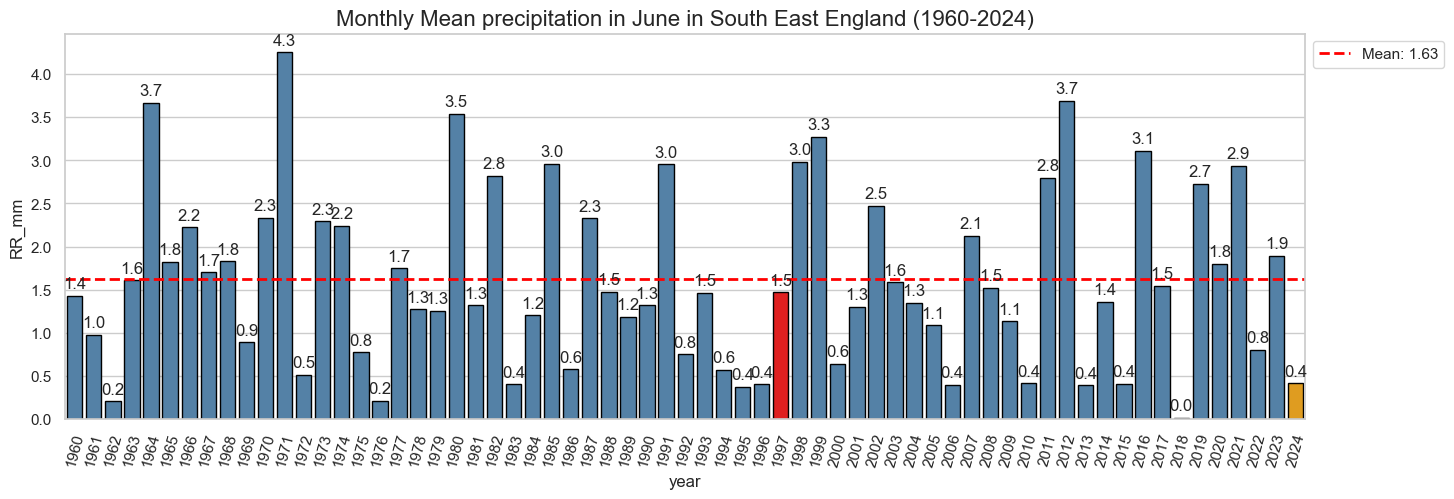

In [20]:
from src.data_plotting import plot_rainfall

test_data = (june_data
             .groupby('year')[['RR', 'RR_mm']]
             .mean()
             .reset_index()
             )

plot_rainfall(test_data, 
              start_year= 1960, 
              latest_year = 2024, 
              feature='RR_mm', 
              special_year=1997, 
              title_label='Monthly Mean precipitation in June', year_shift = False,
              fig_size=(16,5),
              rotation_x_label=75)

In [21]:
heathrow_monthly_sum = (heathrow_daily_data.groupby(['year', 'month'], observed=True)['RR_mm']
                        .sum()
                        .reset_index()
                        )
heathrow_monthly_sum = heathrow_monthly_sum.sort_values(['year', 'month']).reset_index(drop=True).copy()
heathrow_monthly_sum.head()

,year,month,RR_mm
0,1960,Jan,47.9
1,1960,Feb,48.0
2,1960,Mar,33.9
3,1960,Apr,12.4
4,1960,May,45.6


In [22]:
heathrow_daily_data.to_csv('./data/heathrow_daily_data.csv')

In [23]:
rainfall_se = pd.read_pickle('./data/rainfall_se.pkl')
rainfall_data_se = pd.read_pickle('./data/rainfall_data_se.pkl')

rainfall_se.head()

,year,total_rainfall,avg_rainfall,std_rainfall,median_rainfall,max_rainfall,min_rainfall
0,1836,892.4,74.4,29.4,66.4,126.1,21.5
1,1837,622.3,51.9,22.7,48.0,87.5,19.8
2,1838,679.9,56.7,32.3,51.0,122.8,12.9
3,1839,876.0,73.0,35.4,59.5,137.5,25.2
4,1840,601.9,50.2,34.7,49.6,121.6,5.0


In [24]:
rainfall_data_se.head()

,year,month,rainfall,season,assign_weather_year
0,1836,jan,67.7,winter,1835
570,1836,apr,90.7,spring,1835
380,1836,mar,103.1,spring,1835
1330,1836,aug,64.4,summer,1836
1900,1836,nov,100.0,autumn,1836


In [25]:
se_monthly_data = rainfall_data_se[rainfall_data_se['year'] >= 1960].sort_values(['year', 'month']).reset_index(drop = True)[['year', 'month', 'rainfall']].copy()
se_monthly_data.dropna(axis=0, inplace=True)

In [26]:
se_monthly_data = se_monthly_data[:-1].copy()
se_monthly_data.shape

(784, 3)

In [27]:
se_monthly_data.head()

,year,month,rainfall
0,1960,jan,87.4
1,1960,feb,65.8
2,1960,mar,48.0
3,1960,apr,26.0
4,1960,may,43.5


In [28]:
heathrow_monthly_sum.head()

,year,month,RR_mm
0,1960,Jan,47.9
1,1960,Feb,48.0
2,1960,Mar,33.9
3,1960,Apr,12.4
4,1960,May,45.6


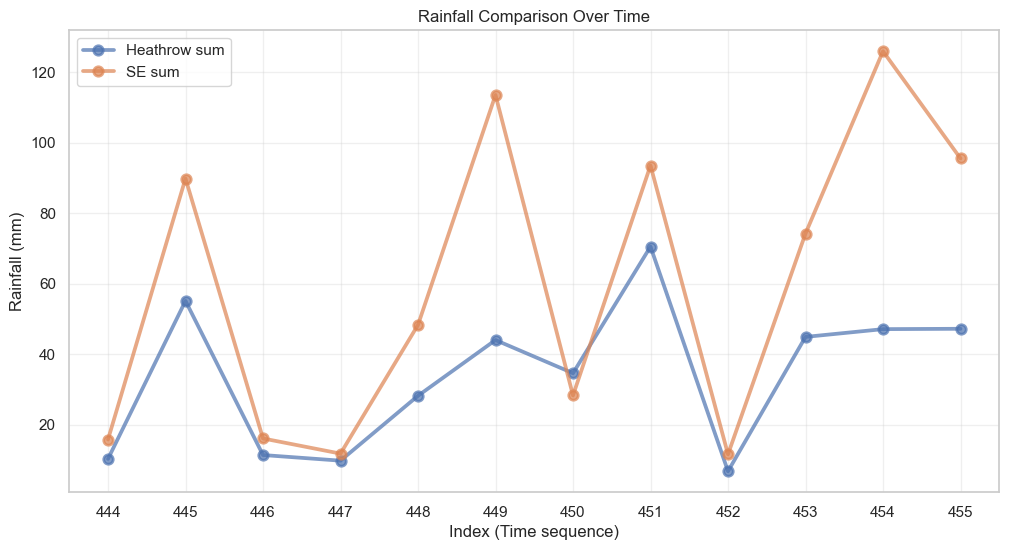

In [29]:
year = 1997
heathrow_test_year = heathrow_monthly_sum[heathrow_monthly_sum['year'] == year]
se_test_year = se_monthly_data[se_monthly_data['year'] == year]

# Create a combined dataframe for easier plotting
combined_df = pd.DataFrame({
    'index': heathrow_test_year.index,
    'RR_mm': heathrow_test_year['RR_mm'],
    'rainfall': se_test_year['rainfall']
})

plt.figure(figsize=(12, 6))
sns.pointplot(data=combined_df, x='index', y='RR_mm', label='Heathrow sum', alpha=0.7)
sns.pointplot(data=combined_df, x='index', y='rainfall', label='SE sum', alpha=0.7)
plt.xlabel('Index (Time sequence)')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Comparison Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

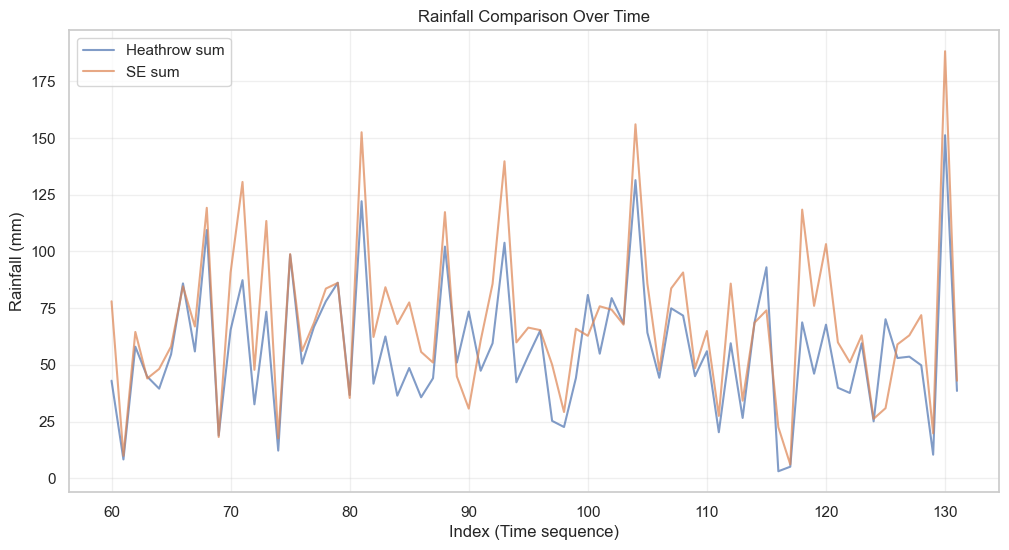

In [30]:
start_year = 1965
end_year = 1970
heathrow_test_year = heathrow_monthly_sum[(heathrow_monthly_sum['year'] >= start_year) &
                                          (heathrow_monthly_sum['year'] <= end_year)]

se_test_year = se_monthly_data[(se_monthly_data['year'] >= start_year) &
                               (se_monthly_data['year'] <= end_year)]

# Create a combined dataframe for easier plotting
combined_df = pd.DataFrame({
    'index': heathrow_test_year.index,
    'RR_mm': heathrow_test_year['RR_mm'],
    'rainfall': se_test_year['rainfall']
})

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='index', y='RR_mm', label='Heathrow sum', alpha=0.7)
sns.lineplot(data=combined_df, x='index', y='rainfall', label='SE sum', alpha=0.7)
plt.xlabel('Index (Time sequence)')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Comparison Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Aggregate analysis

Aggregate analysis - sum, mean, standard deviation, median, min, max.
- Yearly
- First Month
- Weatherly Years

#### Yearly Daily Aggregate

In [31]:
yearly_daily_aggregate = (heathrow_daily_data
                          .groupby('year')
                          .agg(
                              yearly_mm_sum = ('RR_mm', 'sum'),
                              daily_mm_mean = ('RR_mm', 'mean'),
                              daily_mm_std = ('RR_mm', 'std'),
                              daily_mm_median = ('RR_mm', 'median'),
                              daily_mm_min = ('RR_mm', 'min'),
                              daily_mm_max = ('RR_mm', 'max')
                              ).reset_index()
                              )

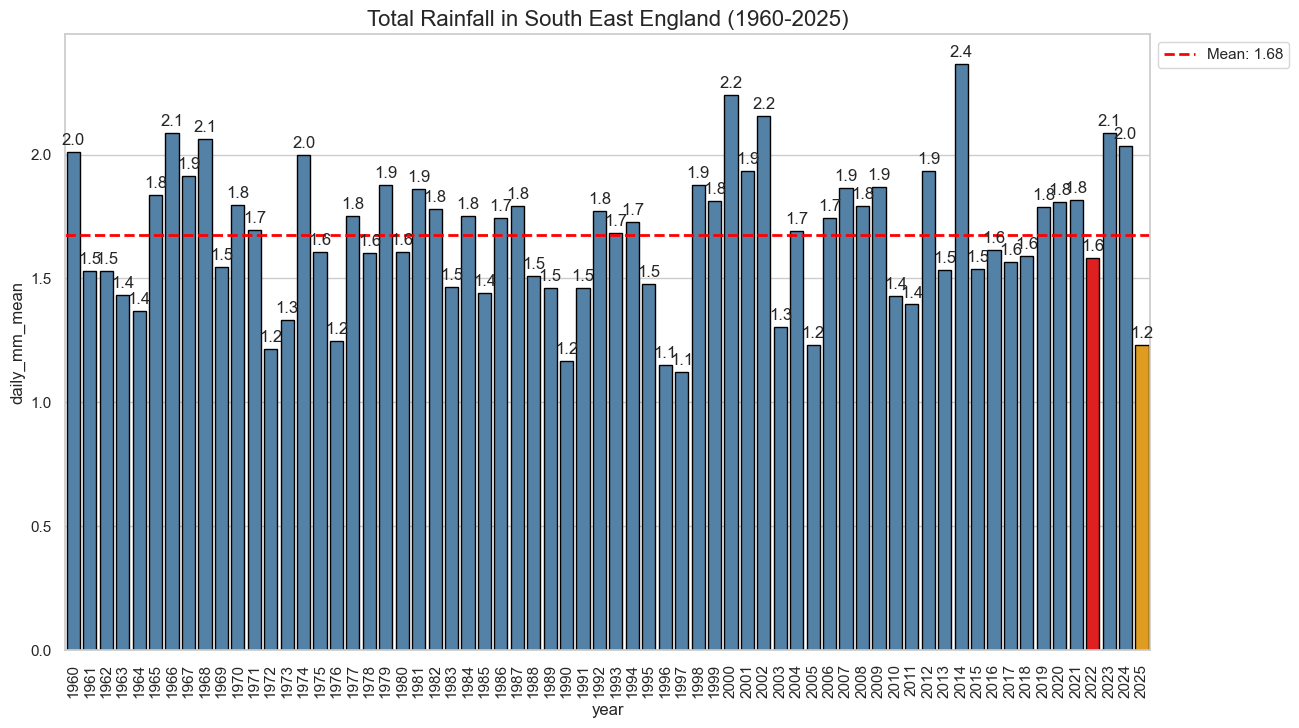

In [32]:
plot_rainfall(yearly_daily_aggregate, 1960, 2025, 'daily_mm_mean', special_year=2022,rotation_x_label=90,fig_size=(14,8));

#### Yearly Monthly Aggregate

In [33]:
yearly_monthly_aggregate = (heathrow_monthly_sum
 .groupby('year')
 .agg(
     yearly_mm_sum = ('RR_mm', 'sum'),
     monthly_mm_mean = ('RR_mm', 'mean'),
     monthly_mm_std = ('RR_mm', 'std'),
     monthly_mm_median = ('RR_mm', 'median'),
     monthly_mm_min = ('RR_mm', 'min'),
     monthly_mm_max = ('RR_mm', 'max')
 ).reset_index()
)

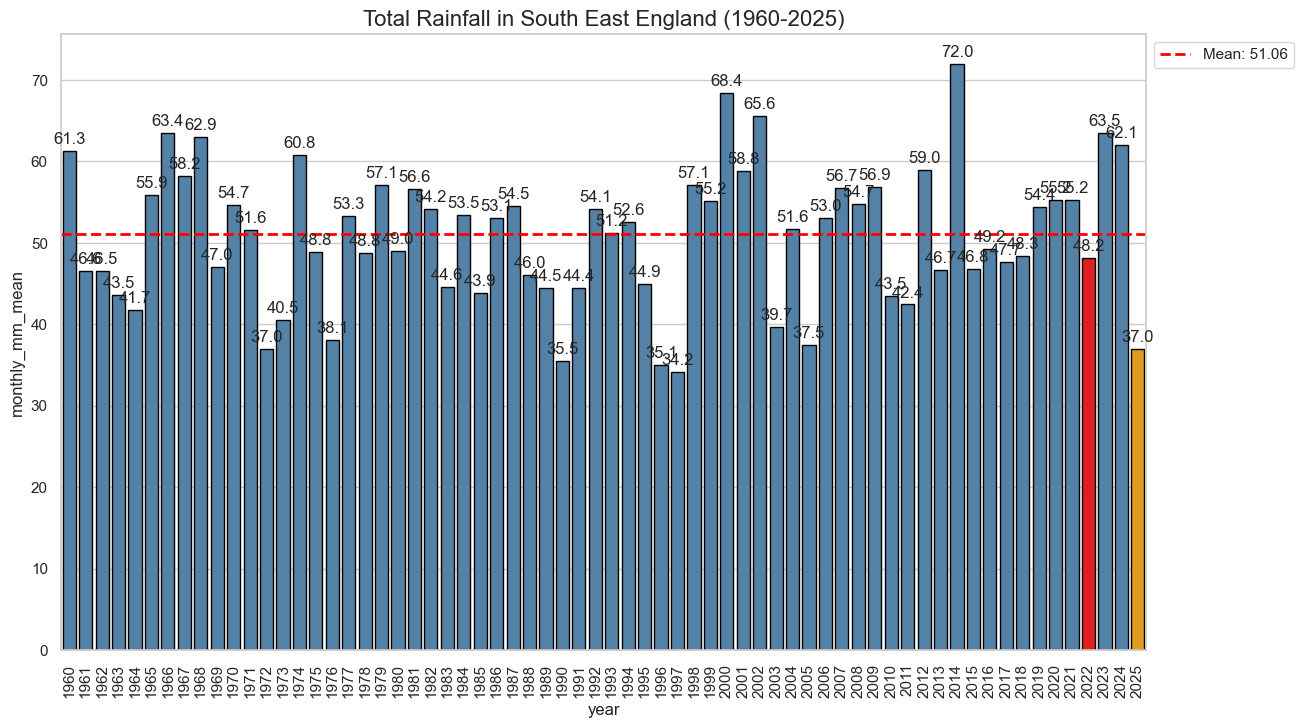

In [34]:
plot_rainfall(yearly_monthly_aggregate, 1960, 2025, 'monthly_mm_mean', special_year=2022,rotation_x_label=90,fig_size=(14,8));

#### First Months Aggregate 

Comparison between the first months of the year. As for 2025 I have data from the fisrt 4 months, the resulting mean may be effected by seasonal variance. If I want to compare yearly monthly mean, I need to do it comparing the same months.

In [35]:
heathrow_daily_data_jan_apr = heathrow_daily_data[heathrow_daily_data['month int'] <= 4].copy()
heathrow_daily_data_jan_apr['month'].unique()

['Jan', 'Feb', 'Mar', 'Apr']
Categories (12, object): ['Jan' < 'Feb' < 'Mar' < 'Apr' ... 'Sep' < 'Oct' < 'Nov' < 'Dec']

In [36]:
yearly_daily_aggregate_jan_apr = (
    heathrow_daily_data_jan_apr.groupby('year')
    .agg(
        yearly_mm_sum = ('RR_mm', 'sum'),
        daily_mm_mean = ('RR_mm', 'mean'),
        daily_mm_std = ('RR_mm', 'std'),
        daily_mm_median = ('RR_mm', 'median'),
        daily_mm_min = ('RR_mm', 'min'),
        daily_mm_max = ('RR_mm', 'max')
    )
    .reset_index()
)

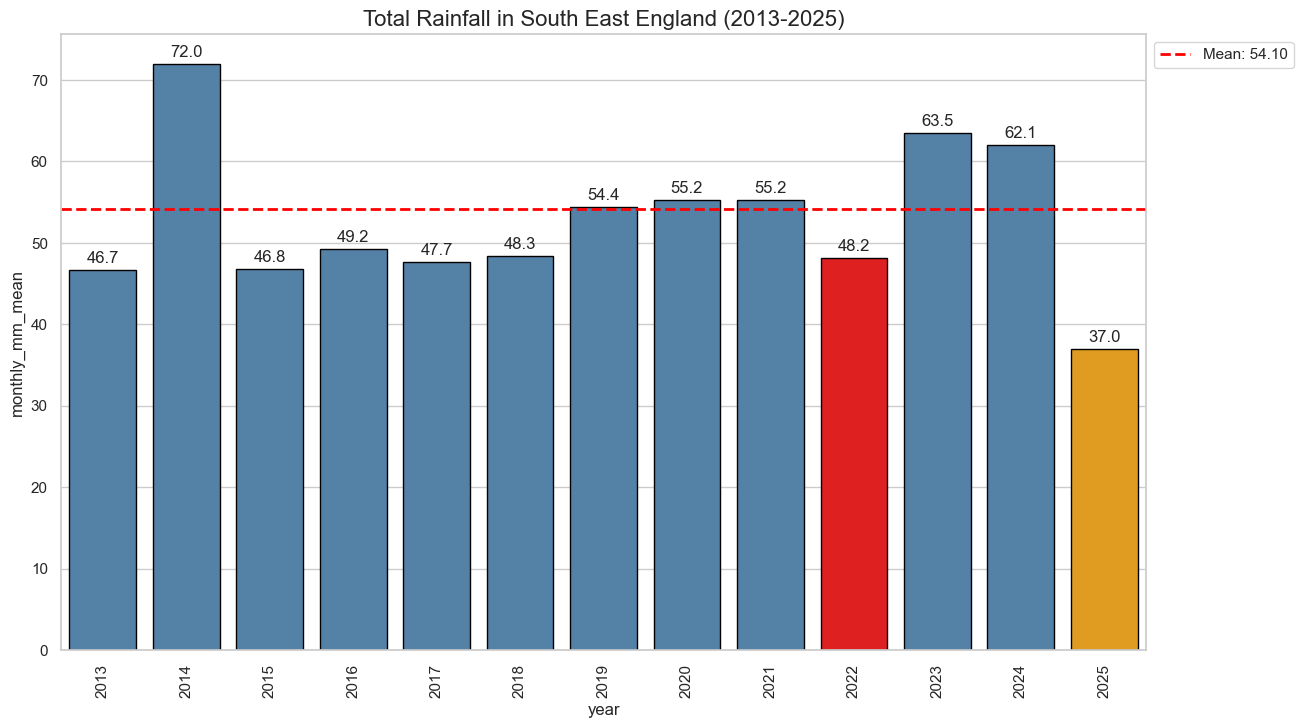

In [37]:
plot_rainfall(yearly_monthly_aggregate, 2013, 2025, 'monthly_mm_mean', special_year=2022,rotation_x_label=90,fig_size=(14,8));

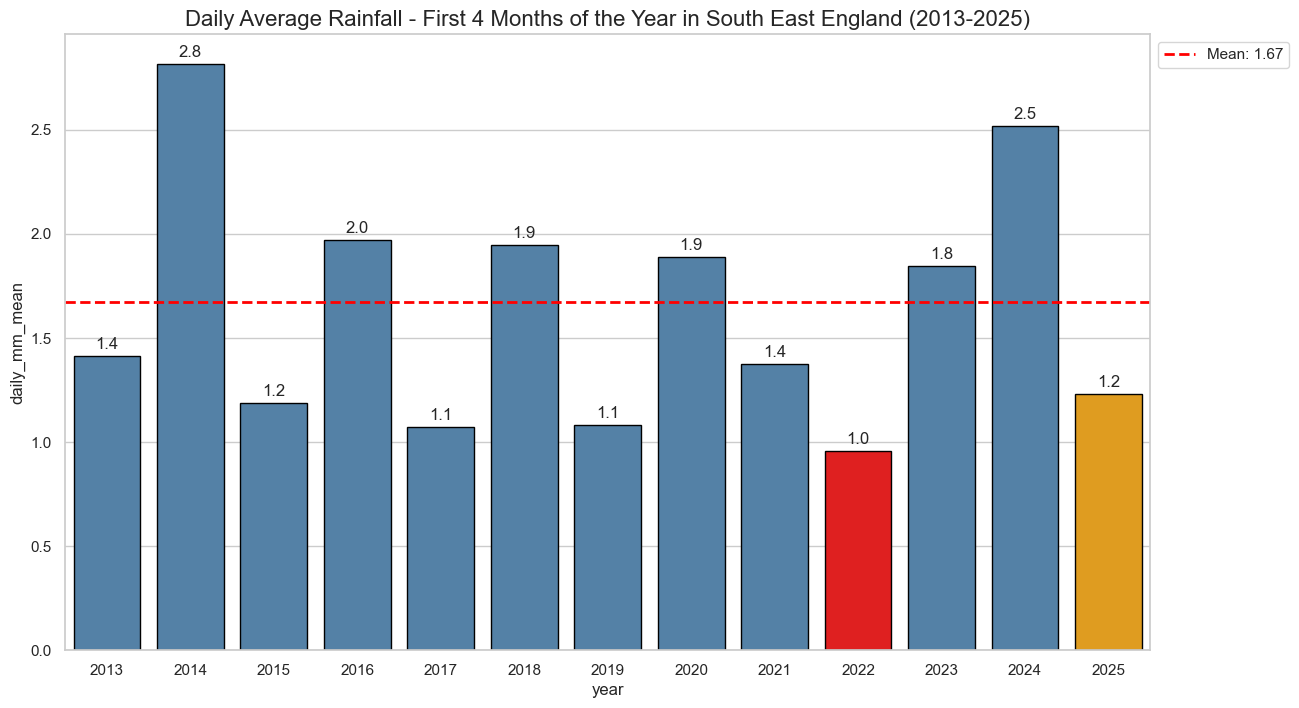

In [38]:
plot_rainfall(yearly_daily_aggregate_jan_apr, 2013, 2025, 'daily_mm_mean', special_year=2022,rotation_x_label=0,fig_size=(14,8), title_label = "Daily Average Rainfall - First 4 Months of the Year");

In [39]:
heathrow_monthly_sum_jan_apr = (
    heathrow_daily_data_jan_apr
        .groupby(['year', 'month'], observed=True)
        .agg(
            monthly_sum=('RR_mm', 'sum')
        )
        .reset_index()
        .rename(columns = {'monthly_sum':'RR_mm'})
)

In [40]:
heathrow_monthly_sum_jan_apr.head()

,year,month,RR_mm
0,1960,Jan,47.9
1,1960,Feb,48.0
2,1960,Mar,33.9
3,1960,Apr,12.4
4,1961,Jan,64.4


In [41]:
yearly_monthly_aggregate_jan_apr = (
    heathrow_monthly_sum_jan_apr
    .groupby('year')
    .agg(
        monthly_sum = ('RR_mm', 'sum'),
        monthly_avg = ('RR_mm', 'mean'),
        monthly_std = ('RR_mm', 'std'),
        monthly_median = ('RR_mm', 'median'),
        monthly_min = ('RR_mm', 'min'),
        monthly_max = ('RR_mm', 'max')

    ).reset_index()
)

yearly_monthly_aggregate_jan_apr.head()

,year,monthly_sum,monthly_avg,monthly_std,monthly_median,monthly_min,monthly_max
0,1960,142.2,35.550,16.794543,40.90,12.4,48.0
1,1961,176.0,44.000,26.156580,52.95,5.7,64.4
2,1962,166.3,41.575,26.235647,38.80,12.6,76.1
3,1963,139.8,34.950,29.942222,32.50,6.6,68.2
4,1964,203.2,50.800,39.676945,45.65,16.8,95.1


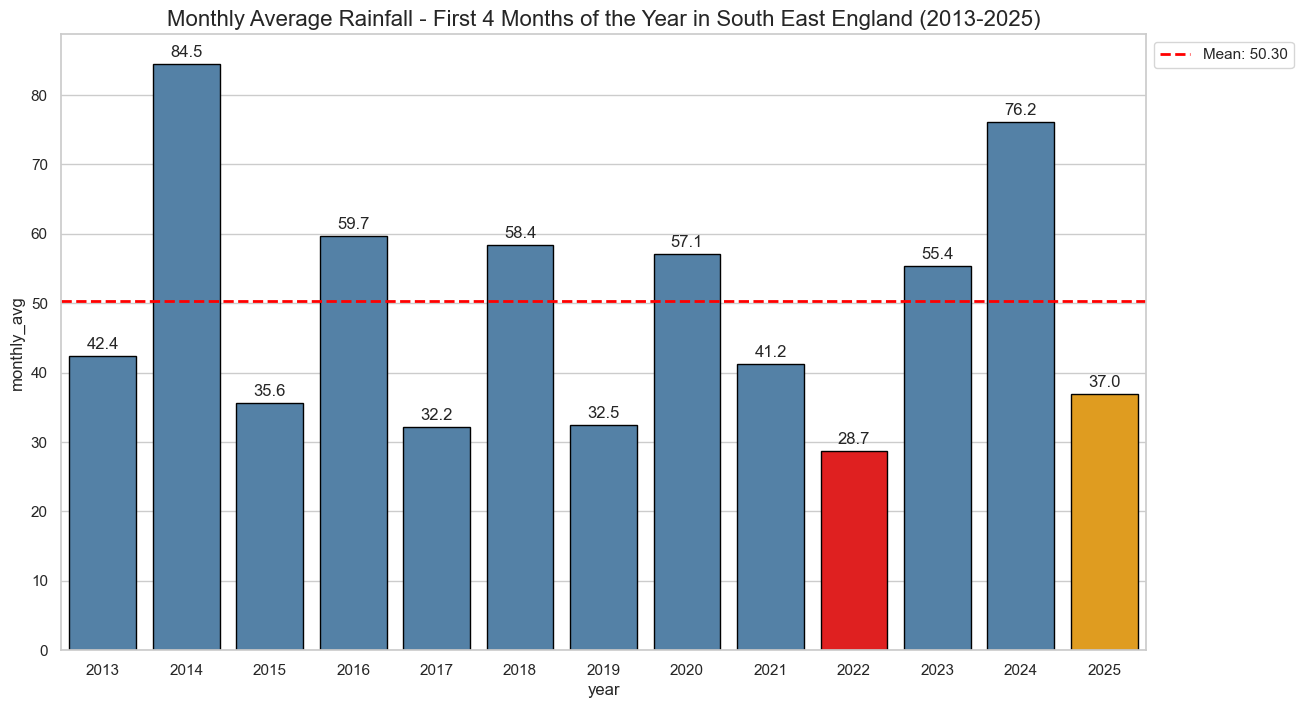

In [42]:
plot_rainfall(yearly_monthly_aggregate_jan_apr, 2013, 2025, 'monthly_avg', 
              special_year=2022,rotation_x_label=0,fig_size=(14,8), 
              title_label = "Monthly Average Rainfall - First 4 Months of the Year");


### Daily Plot

In [43]:
heathrow_daily_data.tail(3)

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm
23859,1860,107650,20250428,0.0,0,2025-04-28,2025,4,Apr,28,0.0
23860,1860,107650,20250429,0.0,0,2025-04-29,2025,4,Apr,29,0.0
23861,1860,107650,20250430,0.0,0,2025-04-30,2025,4,Apr,30,0.0


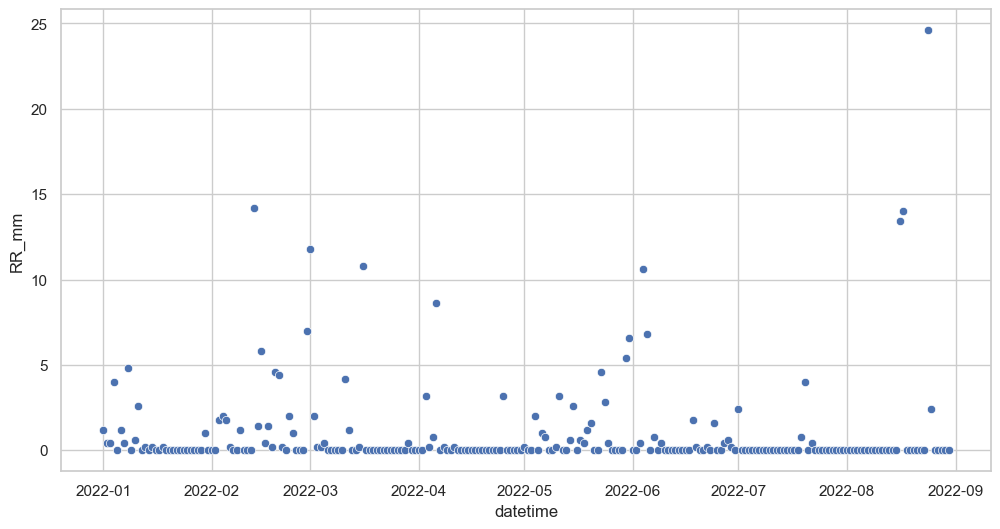

In [44]:
start_date = "2022-01-01"
end_date = "2022-08-30"

plt.figure(figsize=(12, 6))

sns.scatterplot(data = heathrow_daily_data[(heathrow_daily_data['datetime'] >= start_date) & (heathrow_daily_data['datetime'] <= end_date)],
                x = 'datetime',
                y = 'RR_mm'
);

In [45]:
# years = [2010, 2015, 2020, 2022, 2025]
years = [2022, 2025]
start_int_month = 0
end_int_month = 4

test_df = heathrow_daily_data[(heathrow_daily_data['year'].isin(years)) &
                              (heathrow_daily_data['month int'] >= start_int_month) &
                              (heathrow_daily_data['month int'] <= end_int_month)].copy()

test_df['month_day'] = test_df['datetime'].dt.month.astype(str) + '-' + test_df['datetime'].dt.day.astype(str)
test_df.head()

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm,month_day
22646,1860,107650,20220101,12.0,0,2022-01-01,2022,1,Jan,1,1.2,1-1
22647,1860,107650,20220102,4.0,0,2022-01-02,2022,1,Jan,2,0.4,1-2
22648,1860,107650,20220103,4.0,0,2022-01-03,2022,1,Jan,3,0.4,1-3
22649,1860,107650,20220104,40.0,0,2022-01-04,2022,1,Jan,4,4.0,1-4
22650,1860,107650,20220105,0.0,0,2022-01-05,2022,1,Jan,5,0.0,1-5


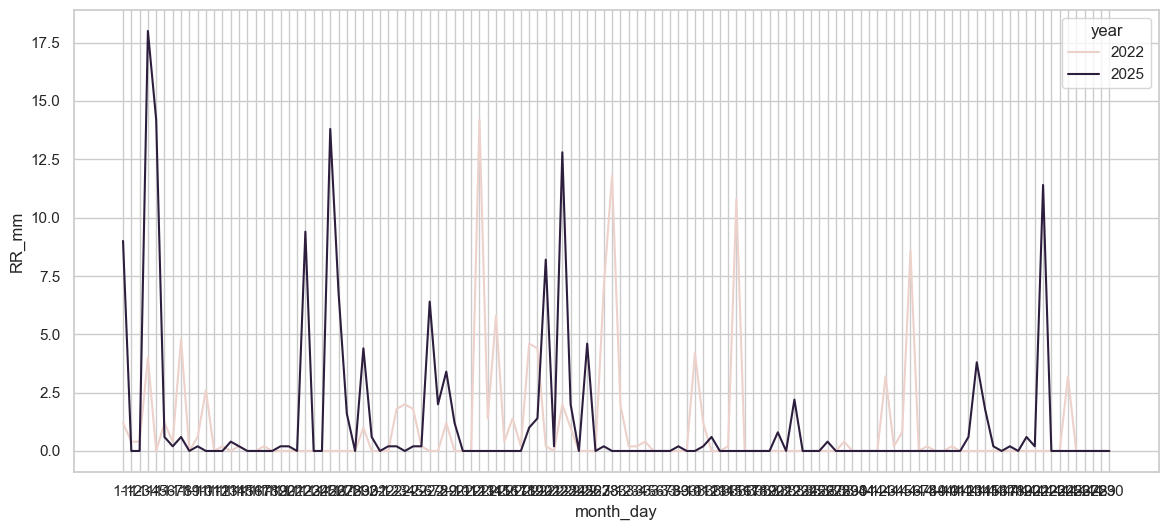

In [46]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data = test_df,
    x = 'month_day',
    y = 'RR_mm',
    hue = 'year'
);

## Number of days (consecutive or not) without precipitation

In [47]:
(heathrow_daily_data['RR']
 .value_counts()
 .reset_index()
).sort_values('RR')

,RR,count
0,0.0,12559
239,0.5,1
3,1.0,620
1,2.0,1351
8,3.0,291
...,...,...
295,531.0,1
278,537.0,1
275,570.0,1
231,594.0,1


In [48]:
12559/heathrow_daily_data.shape[0]

0.5263179951387142

In [49]:
heathrow_daily_data['no_rain'] = 0
heathrow_daily_data.loc[heathrow_daily_data['RR'] == 0, 'no_rain'] = 1
heathrow_daily_data.head()

,STAID,SOUID,DATE,RR,Q_RR,datetime,year,month int,month,day,RR_mm,no_rain
0,1860,107650,19600101,22.0,0,1960-01-01,1960,1,Jan,1,2.2,0
1,1860,107650,19600102,23.0,0,1960-01-02,1960,1,Jan,2,2.3,0
2,1860,107650,19600103,7.0,0,1960-01-03,1960,1,Jan,3,0.7,0
3,1860,107650,19600104,0.0,0,1960-01-04,1960,1,Jan,4,0.0,1
4,1860,107650,19600105,0.0,0,1960-01-05,1960,1,Jan,5,0.0,1


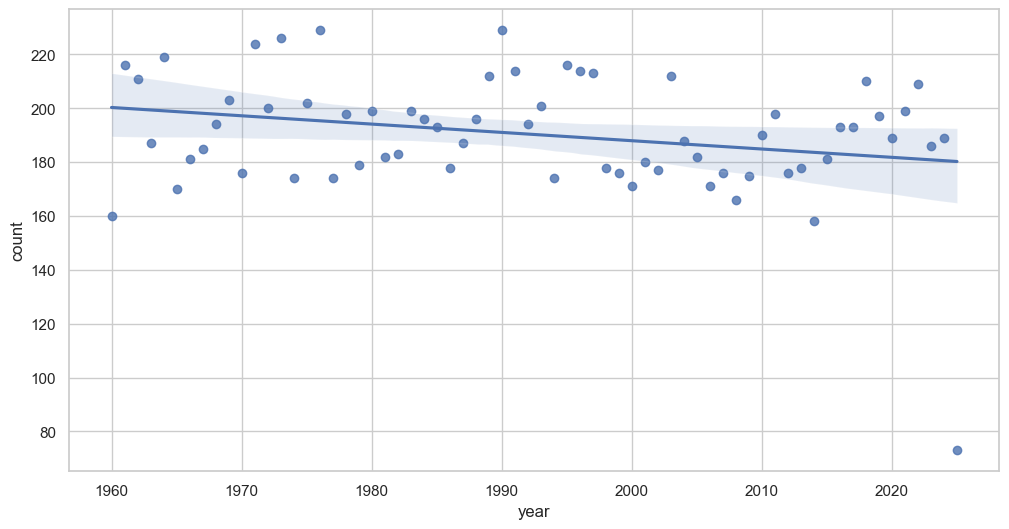

In [50]:
## number of days without rain for each year

no_rainy_days_per_year = heathrow_daily_data[['year', 'no_rain']].value_counts().reset_index().sort_values(['year'])

plt.figure(figsize=(12, 6))

sns.regplot(
    data = no_rainy_days_per_year[no_rainy_days_per_year['no_rain'] == 1],
    x = 'year',
    y = 'count'
);

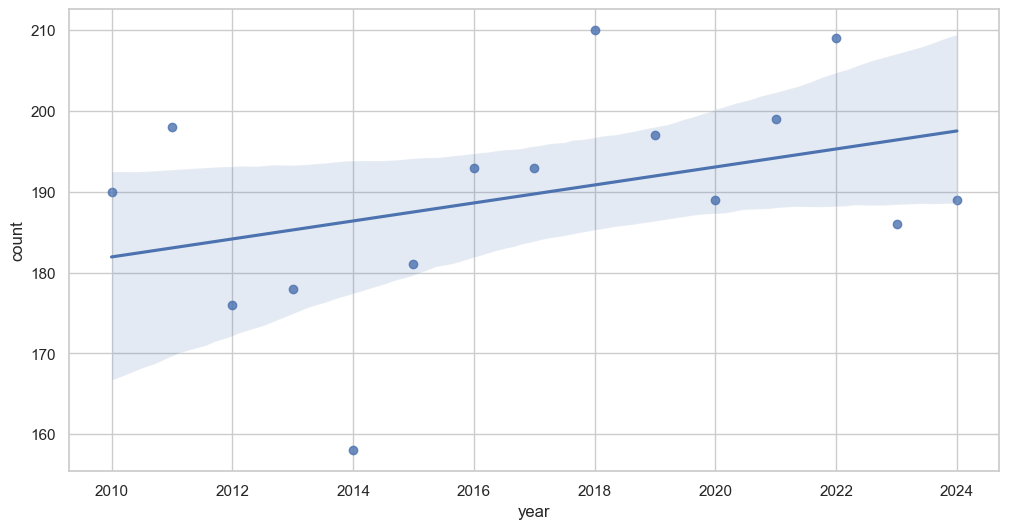

In [51]:
## number of days without rain for each year

no_rainy_days_per_year = heathrow_daily_data[(heathrow_daily_data['year'] >= 2010) & (heathrow_daily_data['year'] < 2025)][['year', 'no_rain']].value_counts().reset_index().sort_values(['year'])

plt.figure(figsize=(12, 6))

sns.regplot(
    data = no_rainy_days_per_year[no_rainy_days_per_year['no_rain'] == 1],
    x = 'year',
    y = 'count'
);

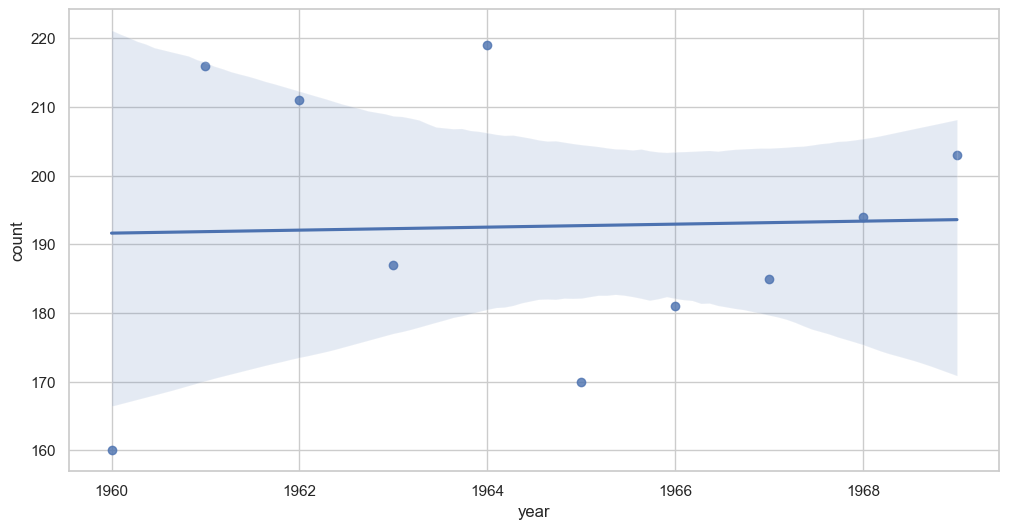

In [52]:
## number of days without rain for each year

no_rainy_days_per_year = heathrow_daily_data[(heathrow_daily_data['year'] >= 1960) & (heathrow_daily_data['year'] < 1970)][['year', 'no_rain']].value_counts().reset_index().sort_values(['year'])

plt.figure(figsize=(12, 6))

sns.regplot(
    data = no_rainy_days_per_year[no_rainy_days_per_year['no_rain'] == 1],
    x = 'year',
    y = 'count'
);

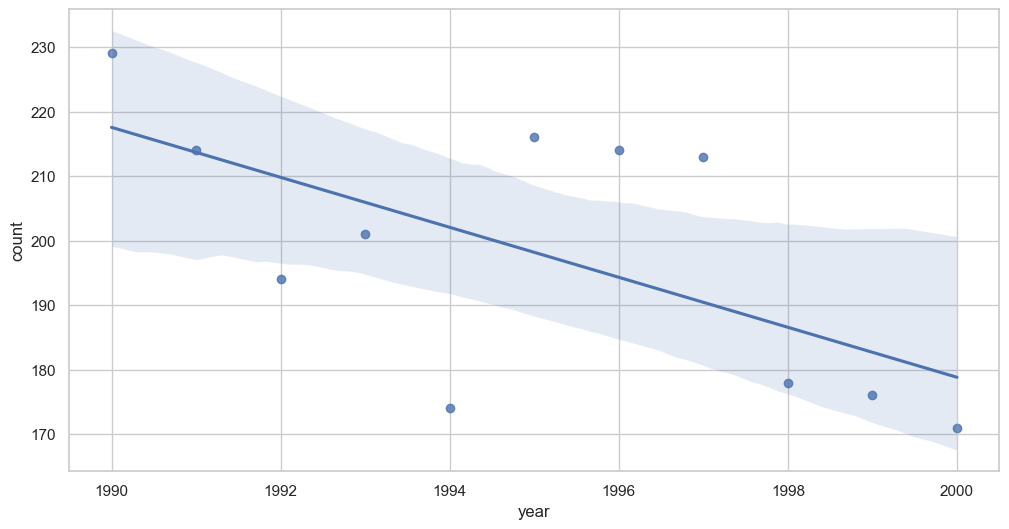

In [53]:
no_rainy_days_per_year_2010 = heathrow_daily_data[(heathrow_daily_data['year'] >= 1990) & (heathrow_daily_data['year'] <= 2000)][['year', 'no_rain']].value_counts().reset_index().sort_values(['year'])

plt.figure(figsize=(12, 6))

sns.regplot(
    data = no_rainy_days_per_year_2010[no_rainy_days_per_year_2010['no_rain'] == 1],
    x = 'year',
    y = 'count'
);

### Number of consecutive days without rain.

In [54]:
# Ensure data is sorted by date
heathrow_daily_data = heathrow_daily_data.sort_values('datetime').reset_index(drop=True)

# Create groups that change each time rain status changes
rain_change = heathrow_daily_data['no_rain'].ne(heathrow_daily_data['no_rain'].shift()).cumsum()

# Count consecutive days within each group, only for no-rain periods
heathrow_daily_data['consecutive_no_rain'] = (
    heathrow_daily_data.groupby(rain_change).cumcount() + 1
).where(heathrow_daily_data['no_rain'] == 1, 0)

In [55]:
heathrow_daily_data[heathrow_daily_data['consecutive_no_rain'] > 20]['year'].value_counts()

year
2018    19
1976    18
2002     7
2023     7
1995     6
1961     5
1971     5
1986     4
1997     4
2022     4
1993     3
1985     2
1962     1
1977     1
1990     1
1991     1
Name: count, dtype: int64

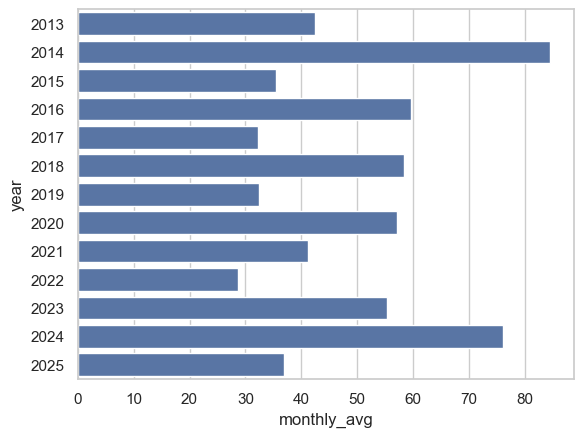

In [59]:
sns.barplot(
    data = yearly_monthly_aggregate_jan_apr[yearly_monthly_aggregate_jan_apr['year'] >=2013],
    x = 'monthly_avg',
    y = 'year',
    orient='h'
);

### Acknowledge

```
EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 11-06-2025
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu
```